202311_jedha_bloc3_ChallengeML
Beraud Mélanie

www.datascienceweekly.org is a famous newsletter curated by independent data scientists. Anyone can register his/her e-mail address on this website to receive weekly news about data science and its applications !


# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots


# Ma palette pour les plotly
pio.templates["mel_purple"] = go.layout.Template(
    layout_colorway=['#FF34B3', '#CD2990', '#8B1C62', '#CD00CD', '#8B008B', '#8968CD', '#5D478B','#20B2AA']) #'#EEA2AD', trop proche

pio.templates.default = "mel_purple"
pio.renderers.default = 'notebook_connected' # to be replaced by "iframe" if working on JULIE

from IPython.display import display

# Read file with labels

In [7]:
# no need to run for EDA
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)


# Preprocessng des new_user as category
data.new_user = data.new_user.astype('category')
data.info()

# super clean : 4 categories for country + 3 categories for source
# Target = converted 0/1 -classification

Set with labels (our train+test) : (284580, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


In [5]:
data.head()

'''
data.columns
Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')
'''

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [15]:
data.describe(include = 'all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.0,284580,284580.000000,284580.000000
unique,4,NaN,2.0,3,NaN,NaN
top,US,NaN,1.0,Seo,NaN,NaN
freq,160124,NaN,195066.0,139477,NaN,NaN
mean,NaN,30.564203,NaN,NaN,4.873252,0.032258
std,NaN,8.266789,NaN,NaN,3.341995,0.176685
min,NaN,17.000000,NaN,NaN,1.000000,0.000000
25%,NaN,24.000000,NaN,NaN,2.000000,0.000000
50%,NaN,30.000000,NaN,NaN,4.000000,0.000000
75%,NaN,36.000000,NaN,NaN,7.000000,0.000000


In [ ]:
# No need anymore ...

data.info() # No Null values
data.new_user.astype('category')
data.info()

for col in data.columns:
    print(col, data[col].value_counts(dropna=False))

# super clean : 4 categories for country + 3 categories for source
# Target = converted 0/1 -classification

# EDA

In [15]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)
data_sample.new_user = data_sample.new_user.astype('category')
data_sample.dtypes

country                  object
age                       int64
new_user               category
source                   object
total_pages_visited       int64
converted                 int64
dtype: object

In [ ]:
# Pairwise dependencies _ no need here
fig = px.scatter_matrix(data_sample)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height = 1200, width = 1200)
fig.show()

In [ ]:
Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [16]:
# recovery of num features and cat features
num_features = []
cat_features = []

for col in data_sample:
    if data_sample[col].dtypes == 'int64' or data_sample[col].dtypes == 'float64':
        num_features.append(col)
    else:
        cat_features.append(col)

num_features = num_features[:-1]
num_features, cat_features


(['age', 'total_pages_visited'], ['country', 'new_user', 'source'])

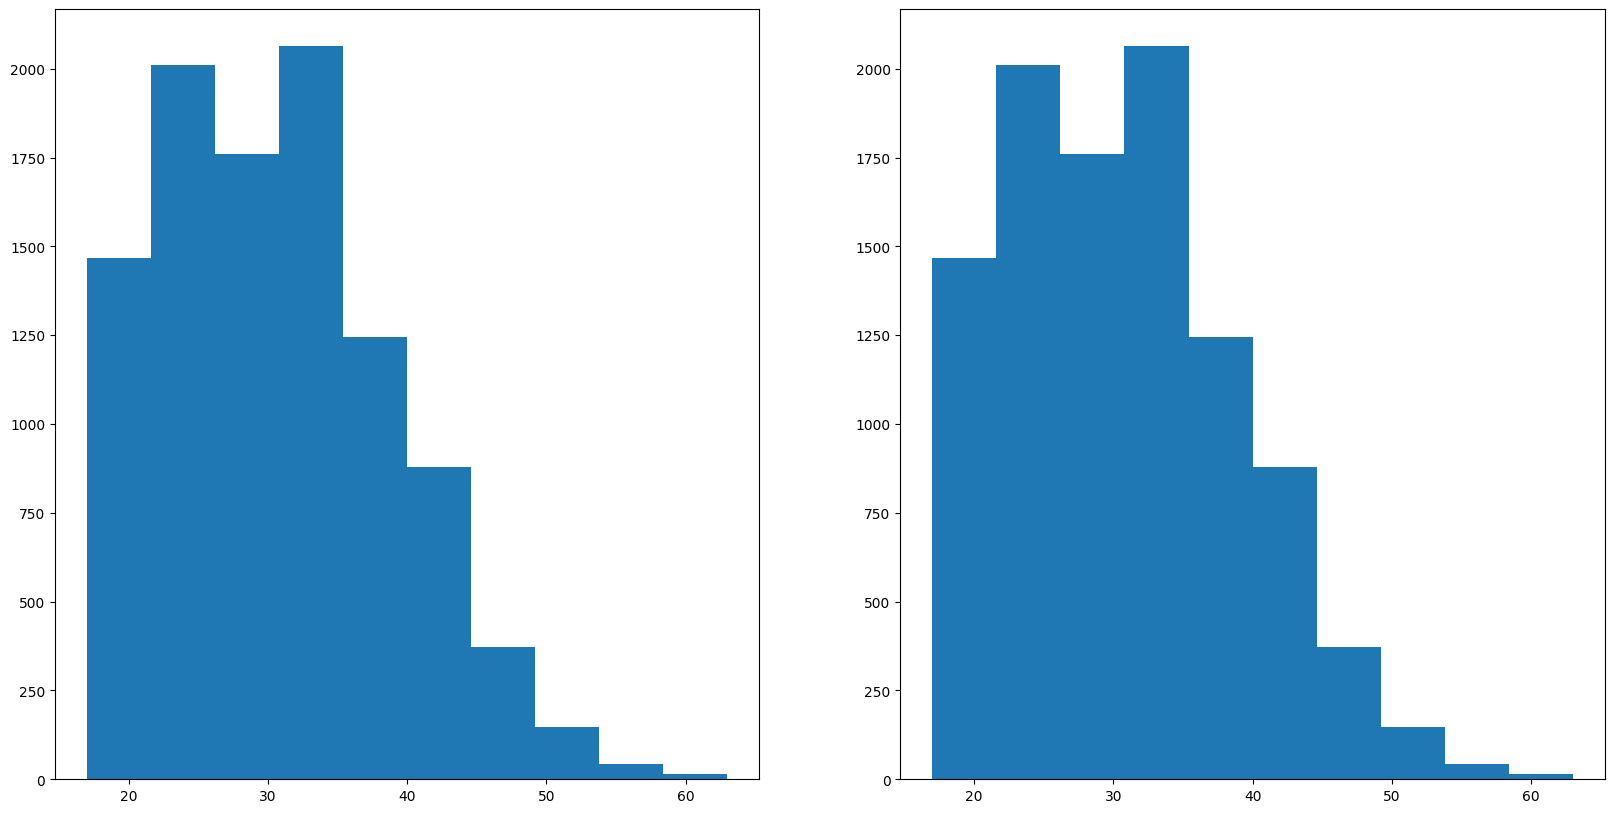

In [55]:
fig, ax = plt.subplots(1,2, figsize=(20, 10))
for axi in ax.flatten():  # enumerate - 0 pour histogramme et 1 box
    axi.hist(data_sample[col])

In [69]:


fig = make_subplots(rows = 1, cols = 2) # figsize=[10,20]

fig.add_trace(px.histogram(data_sample[col], title=f'Distribution {col}').data[0], row = 1, col=1)
fig.add_trace(px.box(data_sample[col], title=f'Distribution {col}').data[0], row = 1, col=2)

for col in num_features:
    fig = make_subplots(rows = 1, cols = 2)#, figsize=[10,20])

    fig.add_trace(px.histogram(data_sample[col], title=f'Distribution {col}').data[0], row = 1, col=1)
    fig.add_trace(px.box(data_sample[col], title=f'Distribution {col}').data[0], row = 1, col=2)
    
    display(fig)

   
    # ne fonctionne pas avec fig, axs & ax[0], ou ax[0,0], ne fonctionne pas avec fig, '(ax1, ax2) et ax1= 


for col in cat_features:
    fig = px.histogram(data_sample[col], title=f'Distribution {col}')
    fig.show()


In [65]:
from plotly.subplots import make_subplots

fig = make_subplots(rows = 1, cols = 2) # figsize=[10,20]

fig.add_trace(px.histogram(data_sample[col], title=f'Distribution {col}').data[0], row = 1, col=1)
fig.add_trace(px.box(data_sample[col], title=f'Distribution {col}').data[0], row = 1, col=2)

In [ ]:
px.(data_sample['country']

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

# OneHotEncoder .... à faire avant

In [ ]:
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [ ]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

In [ ]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Done.")
print()

## Training pipeline

In [ ]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

In [ ]:
# Train model
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

## Test pipeline

In [ ]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

## Performance assessment

In [ ]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

In [ ]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**